In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from keras.models import Model
from keras.layers import Conv2D, BatchNormalization, Layer, Input, MaxPool2D, Activation, Flatten, Dense
from keras.activations import relu
from keras import Sequential
import ntpath
import os
import matplotlib.image as img
import cv2
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


In [ ]:
class ResidualBlock(Layer):
  def __init__(self,num_channels, kernel_size=3, strides=1, use_1x1Conv=False,**kwargs):
    super(ResidualBlock, self).__init__(**kwargs)
    self.conv1 = Conv2D(filters=num_channels // 4, kernel_size=(1, 1), strides=strides, padding='same')
    self.conv2 = Conv2D(filters=num_channels // 4, kernel_size=(3, 3), padding='same')
    self.conv3 = Conv2D(filters=num_channels, kernel_size=(1, 1), padding='same')
    self.conv4 = None
    if use_1x1Conv:
      self.conv4 = Conv2D(filters=num_channels, kernel_size=(1, 1), strides=strides, padding='same')
    self.bn1 = BatchNormalization()
    self.bn2 = BatchNormalization()
    self.bn3 = BatchNormalization()

  def call(self, inputs):
    Y = self.conv1(relu(self.bn1(inputs)))
    Y = self.conv2(relu(self.bn2(Y)))
    Y = self.conv3(relu(self.bn3(Y)))
    if self.conv4 is not None:
      inputs = self.conv4(relu(inputs))
    return Y + inputs

  def get_config(self):
    config = super().get_config().copy()
    config.update({
        'conv1': self.conv1,
        'conv2': self.conv2,
        'conv3': self.conv3,
        'conv4': self.conv4,
        'bn1': self.bn1,
        'bn2': self.bn2,
        'bn3': self.bn3
    })
    return config


In [ ]:
class ResidualStage(Layer):
  def __init__(self, num_of_blocks, num_channels,**kwargs):
    super(ResidualStage, self).__init__(**kwargs)
    self.blocks = []
    for i in range(num_of_blocks):
      if i == 0:
        self.blocks.append(ResidualBlock(num_channels,strides=2,use_1x1Conv=True))
      else:
        self.blocks.append(ResidualBlock(num_channels))

  def call(self, inputs):
    X = inputs
    for block in self.blocks:
      X = block(X)
    return X

  def get_config(self):
    config = super().get_config().copy()
    config.update({
        'blocks': self.blocks,
    })
    return config

In [ ]:
input_size = (40, 40)
model = Sequential([
  Input(shape=(input_size[0], input_size[1], 3)),
  Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='same'), 
  BatchNormalization(),
  Activation('relu'),
  MaxPool2D(pool_size=3, strides=2, padding='same'),
  ResidualStage(3, 256, name='res_stage_1'),
  ResidualStage(4, 512, name='res_stage_2'),
  ResidualStage(6, 1024, name='res_stage_3'),
  ResidualStage(3, 2048, name='res_stage_4'),
  Flatten(),
  Dense(units=100),
  Dense(units=50),
  Dense(units=10),
  Dense(units=1),
])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=tf.keras.metrics.MeanSquaredError()
)

In [ ]:
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 20, 64)        9472      
                                                                 
 batch_normalization (BatchN  (None, 20, 20, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 20, 20, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 64)       0         
 )                                                               
                                                                 
 res_stage_1 (ResidualStage)  (None, 5, 5, 256)        218240    
                                                                 
 res_stage_2 (ResidualStage)  (None, 3, 3, 512)        1

In [ ]:
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
datadir = '/content/drive/MyDrive/college/deep-learning-project/try1'
df = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
df.head()


,center,left,right,steering,throttle,reverse,speed
0,E:\data\try1\IMG\center_2022_05_04_07_47_37_82...,E:\data\try1\IMG\left_2022_05_04_07_47_37_820.jpg,E:\data\try1\IMG\right_2022_05_04_07_47_37_820...,0.0,0.000000,0,0.000022
1,E:\data\try1\IMG\center_2022_05_04_07_47_37_89...,E:\data\try1\IMG\left_2022_05_04_07_47_37_892.jpg,E:\data\try1\IMG\right_2022_05_04_07_47_37_892...,0.0,0.086451,0,0.007195
2,E:\data\try1\IMG\center_2022_05_04_07_47_37_96...,E:\data\try1\IMG\left_2022_05_04_07_47_37_961.jpg,E:\data\try1\IMG\right_2022_05_04_07_47_37_961...,0.0,0.279831,0,0.185616
3,E:\data\try1\IMG\center_2022_05_04_07_47_38_03...,E:\data\try1\IMG\left_2022_05_04_07_47_38_034.jpg,E:\data\try1\IMG\right_2022_05_04_07_47_38_034...,0.0,0.527614,0,0.550891
4,E:\data\try1\IMG\center_2022_05_04_07_47_38_10...,E:\data\try1\IMG\left_2022_05_04_07_47_38_101.jpg,E:\data\try1\IMG\right_2022_05_04_07_47_38_101...,0.0,0.707878,0,0.987006


In [ ]:
def get_path_tail(path):
  _, tail = ntpath.split(path)
  return tail

for i in range(3):
  df[columns[i]] = df[columns[i]].apply(get_path_tail)

df.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2022_05_04_07_47_37_820.jpg,left_2022_05_04_07_47_37_820.jpg,right_2022_05_04_07_47_37_820.jpg,0.0,0.000000,0,0.000022
1,center_2022_05_04_07_47_37_892.jpg,left_2022_05_04_07_47_37_892.jpg,right_2022_05_04_07_47_37_892.jpg,0.0,0.086451,0,0.007195
2,center_2022_05_04_07_47_37_961.jpg,left_2022_05_04_07_47_37_961.jpg,right_2022_05_04_07_47_37_961.jpg,0.0,0.279831,0,0.185616
3,center_2022_05_04_07_47_38_034.jpg,left_2022_05_04_07_47_38_034.jpg,right_2022_05_04_07_47_38_034.jpg,0.0,0.527614,0,0.550891
4,center_2022_05_04_07_47_38_101.jpg,left_2022_05_04_07_47_38_101.jpg,right_2022_05_04_07_47_38_101.jpg,0.0,0.707878,0,0.987006


In [ ]:
def load_img_steering(datadir, df):
  """Get img and steering data into arrays"""
  image_path = []
  steering = []
  for i in range(len(df)):
    indexed_data = df.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings[:, np.newaxis]

image_paths, steerings = load_img_steering(datadir + '/IMG' , df)



In [ ]:
def preprocess_images(paths, img_size):
  images = []
  for i in range(len(paths)):
    image = img.imread(paths[i])
    image = cv2.resize(image, img_size) / 255
    images.append(image)
    print(f'loaded {i+1}/{len(paths)} images')
  return np.array(images)

In [ ]:
images = preprocess_images(image_paths, input_size)

loaded 1/2831 images
loaded 2/2831 images
loaded 3/2831 images
loaded 4/2831 images
loaded 5/2831 images
loaded 6/2831 images
loaded 7/2831 images
loaded 8/2831 images
loaded 9/2831 images
loaded 10/2831 images
loaded 11/2831 images
loaded 12/2831 images
loaded 13/2831 images
loaded 14/2831 images
loaded 15/2831 images
loaded 16/2831 images
loaded 17/2831 images
loaded 18/2831 images
loaded 19/2831 images
loaded 20/2831 images
loaded 21/2831 images
loaded 22/2831 images
loaded 23/2831 images
loaded 24/2831 images
loaded 25/2831 images
loaded 26/2831 images
loaded 27/2831 images
loaded 28/2831 images
loaded 29/2831 images
loaded 30/2831 images
loaded 31/2831 images
loaded 32/2831 images
loaded 33/2831 images
loaded 34/2831 images
loaded 35/2831 images
loaded 36/2831 images
loaded 37/2831 images
loaded 38/2831 images
loaded 39/2831 images
loaded 40/2831 images
loaded 41/2831 images
loaded 42/2831 images
loaded 43/2831 images
loaded 44/2831 images
loaded 45/2831 images
loaded 46/2831 imag

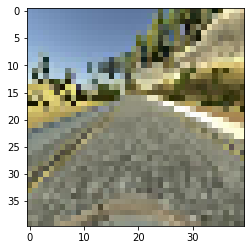

In [ ]:
plt.imshow(images[np.random.randint(0, images.shape[0] - 1)])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, steerings, test_size=0.3, random_state=42)
X_validate, X_test, y_validate, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print(f'X_training_size: {X_train.shape}')
print(f'X_validation_size: {X_validate.shape}')
print(f'X_testing_size: {X_test.shape}')

print(f'y_training_size: {y_train.shape}')
print(f'y_validation_size: {y_validate.shape}')
print(f'y_testing_size: {y_test.shape}')

X_training_size: (1981, 40, 40, 3)
X_validation_size: (425, 40, 40, 3)
X_testing_size: (425, 40, 40, 3)
y_training_size: (1981, 1)
y_validation_size: (425, 1)
y_testing_size: (425, 1)


In [ ]:
history= model.fit(
   X_train, y_train,
   batch_size=128,
   epochs=25,
   validation_data = (X_validate, y_validate)
)

Epoch 1/25
16/16 [==============================] - 131s 8s/step - loss: 817.5359 - mean_squared_error: 817.5359 - val_loss: 0.0774 - val_mean_squared_error: 0.0774
Epoch 2/25
16/16 [==============================] - 121s 8s/step - loss: 6.9743 - mean_squared_error: 6.9743 - val_loss: 0.0564 - val_mean_squared_error: 0.0564
Epoch 3/25
16/16 [==============================] - 120s 7s/step - loss: 0.8853 - mean_squared_error: 0.8853 - val_loss: 0.0291 - val_mean_squared_error: 0.0291
Epoch 4/25
16/16 [==============================] - 122s 8s/step - loss: 0.2244 - mean_squared_error: 0.2244 - val_loss: 0.0372 - val_mean_squared_error: 0.0372
Epoch 5/25
16/16 [==============================] - 124s 8s/step - loss: 0.0871 - mean_squared_error: 0.0871 - val_loss: 0.0330 - val_mean_squared_error: 0.0330
Epoch 6/25
16/16 [==============================] - 121s 8s/step - loss: 0.0412 - mean_squared_error: 0.0412 - val_loss: 0.0314 - val_mean_squared_error: 0.0314
Epoch 7/25
16/16 [============

Text(0.5, 0, 'Epoch')

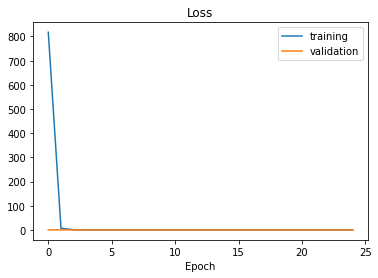

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
loss, mse = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_test.shape, y_pred.shape

14/14 [==============================] - 1s 100ms/step - loss: 0.0561 - mean_squared_error: 0.0561


((425, 1), (425, 1))

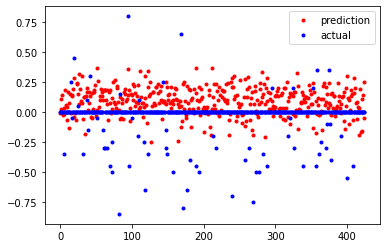

In [ ]:
plt.plot(y_pred, 'r.', label='prediction')
plt.plot(y_test, 'b.', label='actual')
plt.legend()
plt.show()

In [ ]:
# model.save('/content/drive/MyDrive/college/deep-learning-project/models/v1.h5', 'h5')